# [Module 3] cvr 데이터 생성

이 워크샵은 기본 커널을 conda_python3를 사용합니다.

## 0. 환경 설정

#### Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다.

In [1]:
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt

변수 로딩

In [2]:
%store -r

## 1. CVR data set 생성

In [3]:
def cvr_fomula(s):
    o = s['Purchase']
    v = s['View']
    
    if v <= o: # order is greater than view
        CVR = (o - ((0.99 ** o) * o)) / (o + v)          
    elif o < 100 : # view is greater than 100
        CVR = ( (o - ((0.99 ** o) * o)) / v )     
    elif v <= 100: 
        CVR = (o - (0.5 ** o)) / v        
    elif v > 100: # view is greater than 100
        CVR = (o  / (v))
    
    # CVR 값에 100을 곱해서 표준화
    CVR = CVR * 100
    return round(CVR,5)

In [4]:
def create_cvr_optimize_dataset(df):
    df = df.groupby(by=['ITEM_ID', 'EVENT_TYPE']).agg({'USER_ID' : 'count'})    
    df = df.unstack().fillna(0)    
    order = df[('USER_ID', 'Purchase')]
    view = df[('USER_ID', 'View')]    
    df = pd.DataFrame(data={'View': view, 'Purchase': order}).reset_index()

    cols = ['View','Purchase']
    df['CVR'] = df[cols].apply(cvr_fomula, axis=1)
    df['View'] = df['View'].astype(int)
    df['Purchase'] = df['Purchase'].astype(int)    
    
    return df

In [5]:
cvr_dataset = create_cvr_optimize_dataset(interactions_df)

In [6]:
cvr_dataset

,ITEM_ID,View,Purchase,CVR
0,00096972-5f6b-44df-917b-f7d21ae5644c,217,3,0.04106
1,0016fde3-0910-4cc1-8ef6-90e15f271073,283,2,0.01406
2,00225258-dbfb-4103-a573-007386571a49,233,4,0.06765
3,003e4953-d6cb-400c-90f6-9b0216b4603e,245,3,0.03637
4,004112e9-dca1-4402-ae6d-74e2b80b8c05,256,3,0.03481
...,...,...,...,...
2444,ff973006-27da-45dd-899c-8441c5eaebe0,267,4,0.05903
2445,ff9c5ec9-69d0-4338-b4b2-96d48b2e91aa,284,3,0.03137
2446,ffbf120a-0b8e-41dd-bbe9-5b2a87b0c8c5,255,3,0.03494
2447,ffcc4cc8-a094-49ea-b9f2-8bf056261868,231,2,0.01723


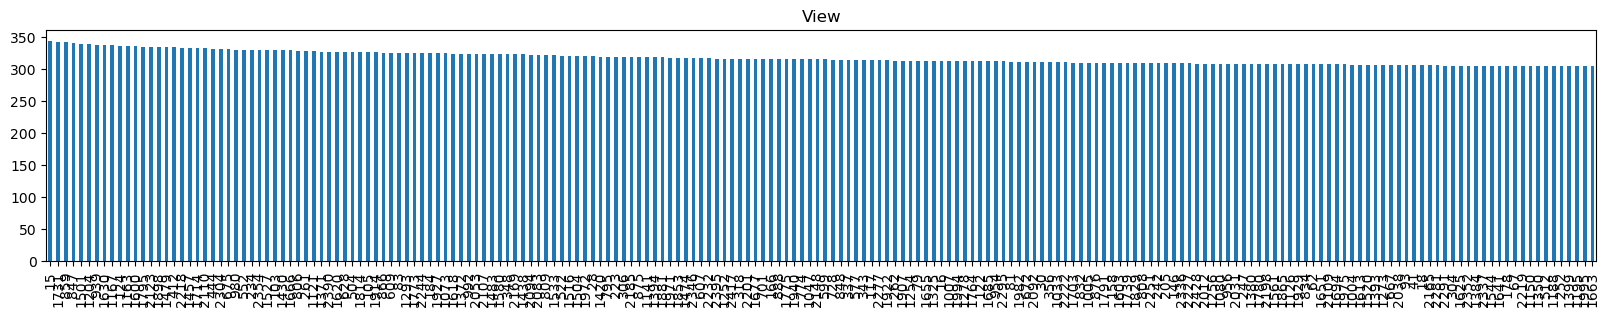

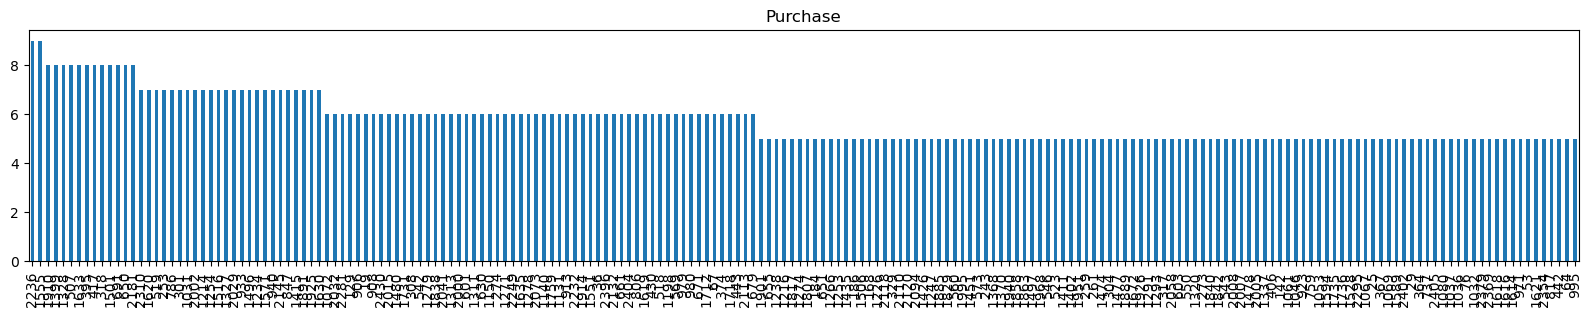

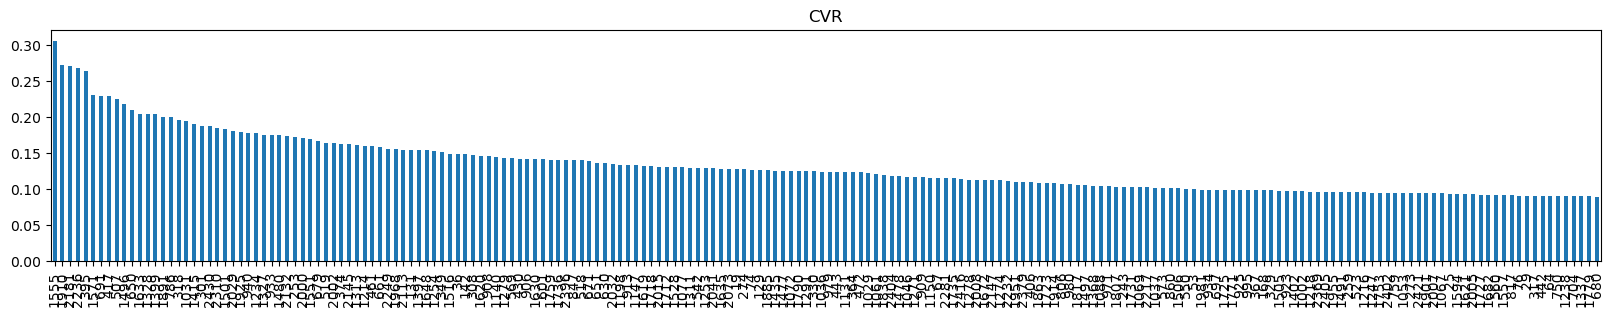

In [7]:
import matplotlib.pyplot as plt    
def show_cvar_chart(df, num):
    top = df['View'].sort_values(ascending=False).head(num)
    top.plot.bar(figsize=(20,3), title='View')
    plt.show()
    top = df['Purchase'].sort_values(ascending=False).head(num)
    top.plot.bar(figsize=(20,3), title='Purchase')
    plt.show()
    top = df['CVR'].sort_values(ascending=False).head(num)
    top.plot.bar(figsize=(20,3), title='CVR')
    plt.show()
    

show_cvar_chart(cvr_dataset, num=200)

## 2. CVR 값을 Items 데이터셋에 삽입하여 새로운 Item 데이터프레임 생성

새로운 Items 데이터프레임(items_cvr_df)는 인터렉션(View, Purchase)이 있었던 아이템만으로 선별됩니다.

In [10]:
def create_item_cvr(cvr_df, item_df, cols):
    df = pd.merge(left= cvr_df, right = item_df, how= 'inner', on= 'ITEM_ID')    
    df = df[cols]
    
    return df
    

In [11]:
cols = ["ITEM_ID", "CVR", "NAME", "CATEGORY_L1", "STYLE", "PRODUCT_DESCRIPTION", "PRICE"]

items_cvr_df = create_item_cvr(cvr_dataset, items_df, cols)

In [12]:
items_cvr_df

,ITEM_ID,CVR,NAME,CATEGORY_L1,STYLE,PRODUCT_DESCRIPTION,PRICE
0,00096972-5f6b-44df-917b-f7d21ae5644c,0.04106,Pink Shirt,apparel,shirt,Swanky dress for women,225.99
1,0016fde3-0910-4cc1-8ef6-90e15f271073,0.01406,Farmed Salmon For Sushi,groceries,seafood,"Flavorful farmed salmon, always sourced sustai...",24.99
2,00225258-dbfb-4103-a573-007386571a49,0.06765,Easter Decorative Egg,seasonal,easter,A must-have for April,16.99
3,003e4953-d6cb-400c-90f6-9b0216b4603e,0.03637,Drought-Resistant Indoor Plant,floral,plant,Drought-resistant indoor plant grown sustainab...,76.99
4,004112e9-dca1-4402-ae6d-74e2b80b8c05,0.03481,Mango Coat,apparel,jacket,Mango coat for men about town,184.99
...,...,...,...,...,...,...,...
2444,ff973006-27da-45dd-899c-8441c5eaebe0,0.05903,Groovy Glasses,accessories,glasses,These groovy glasses for men are unparalleled,140.99
2445,ff9c5ec9-69d0-4338-b4b2-96d48b2e91aa,0.03137,Black Shirt,apparel,shirt,Black casual shirt for men,226.99
2446,ffbf120a-0b8e-41dd-bbe9-5b2a87b0c8c5,0.03494,Bread,groceries,bakery,Bread made fresh daily in our kitchens,7.99
2447,ffcc4cc8-a094-49ea-b9f2-8bf056261868,0.01723,Indoor Plant,floral,plant,Indoor plant delivered fresh and vibrant from ...,129.99


## 3. 변수 저장

다음 노트북에서 활용할 변수를 저장 합니다.

In [13]:
%store items_cvr_df

Stored 'items_cvr_df' (DataFrame)
